# Import Modules and Define Useful Functions

In [1]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import json
import csv
import pandas as pd
import sklearn.feature_extraction.text as sk_text
import io
import requests
import numpy as np
import time
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import display
from matplotlib.pyplot import figure

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a confusion matrix.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a coefficient chart.
def report_coef(names,coef,intercept):
    #plt.figure(figsize=(18,270))
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    #r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    #plt.figure(figsize=(8,6))

#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
#We modified this to make it more powerful, full dataframe normalization
def encode_numeric_range(df, list, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    for i in range (0,len(list)):
        if data_low is None:
            data_low = min(df[list[i]])
            data_high = max(df[list[i]])
        df[list[i]] = ((df[list[i]] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
        data_low=None
        
#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
#Plot a regression chart
def chart_regression(pred,y,sort=True):
    plt.figure(figsize=(16,10))
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8,6))

#fix headers for census data
def fix_table(df,dropig=True):
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    df = df.astype({"Id2" : int})
    if dropig:
        df = df.drop(['Id','Geography'],axis=1)
    #drop DC and PR elections (they are for non-voting delagates) and cause lots of problems
    df.drop(df[df['Id2']%100==98].index, inplace=True)
    return df

# Code Used to Load the Census Data into a Dataframe

In [2]:
dp1  = pd.read_csv('census_data/DEC_00_110H_DP1_with_ann.csv', encoding="utf-8")
dp2  = pd.read_csv('census_data/DEC_00_110S_DP2_with_ann.csv', encoding="utf-8")
dp3  = pd.read_csv('census_data/DEC_00_110S_DP3_with_ann.csv', encoding="utf-8")
dp4  = pd.read_csv('census_data/DEC_00_110S_DP4_with_ann.csv', encoding="utf-8")
h002 = pd.read_csv('census_data/DEC_00_110H_H002_with_ann.csv', encoding="utf-8")

#fix headers
dp1  = fix_table(dp1, False)
dp2  = fix_table(dp2)
dp3  = fix_table(dp3)
dp4  = fix_table(dp4)
h002 = fix_table(h002)

df = dp1.copy()
df = df.merge(dp2,on="Id2")
df = df.merge(dp3,on="Id2")
df = df.merge(dp4,on="Id2")
df = df.merge(h002,on="Id2")

#fix typo in header
df.rename(columns={'Rural' : 'Rural:'},inplace=True)

#Cleaning useless columns
df.drop('Id', axis=1, inplace=True)
#df.drop('Id2', axis=1, inplace=True)
df.drop('Geography', axis=1, inplace=True)
df.drop('Not defined for this file', axis=1, inplace=True)
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.drop(list(df.filter(regex = 'Percent;')), axis = 1, inplace = True)

#fix types
df = df.astype(float)
df = df.astype({"Id2" : int})

#DONT OVERWRITE df IT NEEDS TO BE USED BY MULTIPLE MODELS AND EACH WILL WILL MAKE ITS OWN MODIFICATIONS TO DF
#get a copy using 'copy_of_df = df.copy()'
df

,Id2,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,101,635300.0,306620.0,328680.0,44487.0,47766.0,48163.0,47183.0,40743.0,82555.0,...,7284.0,6086.0,4146.0,18943.0,8395.0,281691.0,175729.0,133997.0,41732.0,105962.0
1,102,635300.0,308305.0,326995.0,42135.0,45367.0,46806.0,46145.0,43293.0,86835.0,...,7540.0,6036.0,4369.0,17616.0,10306.0,281290.0,136673.0,82178.0,54495.0,144617.0
2,103,635300.0,305852.0,329448.0,40841.0,44217.0,44661.0,50575.0,53426.0,84285.0,...,7114.0,5686.0,4166.0,22127.0,10631.0,286010.0,150521.0,113943.0,36578.0,135489.0
3,104,635300.0,310279.0,325021.0,40985.0,42916.0,43443.0,43253.0,37919.0,84993.0,...,5285.0,4803.0,2891.0,10959.0,10336.0,282766.0,76421.0,31756.0,44665.0,206345.0
4,105,635300.0,309694.0,325606.0,41451.0,44864.0,45366.0,44357.0,40175.0,87387.0,...,8144.0,6459.0,4549.0,17484.0,7688.0,278684.0,169089.0,147823.0,21266.0,109595.0
5,106,635300.0,310240.0,325060.0,41352.0,43273.0,44813.0,41260.0,38497.0,92508.0,...,6692.0,5131.0,3179.0,12319.0,6218.0,271212.0,169584.0,154689.0,14895.0,101628.0
6,107,635300.0,295514.0,339786.0,44741.0,46942.0,47000.0,51807.0,52812.0,84452.0,...,9297.0,7224.0,6176.0,28901.0,11932.0,282058.0,202666.0,186106.0,16560.0,79392.0
7,200,626932.0,324112.0,302820.0,47591.0,53771.0,56661.0,50094.0,39892.0,89473.0,...,10141.0,8082.0,6095.0,20903.0,11534.0,260978.0,157834.0,108417.0,49417.0,103144.0
8,401,641329.0,325515.0,315814.0,44745.0,50084.0,53966.0,51215.0,42419.0,75619.0,...,6721.0,5586.0,4143.0,17739.0,8408.0,293918.0,149292.0,51821.0,97471.0,144626.0
9,402,641329.0,313683.0,327646.0,40887.0,43918.0,43968.0,39237.0,31869.0,76244.0,...,6351.0,5552.0,3893.0,15875.0,4956.0,287665.0,253368.0,188931.0,64437.0,34297.0


In [3]:
#Check dataframe for NAN values
df.isnull().sum().sum()

0

# Print All the Column Names That Are in the Input Dataframe

In [4]:
columnnames = list(df.columns)
print('\n'.join(map(str, columnnames)))

Id2
Number; Total population
Number; Total population - SEX AND AGE - Male
Number; Total population - SEX AND AGE - Female
Number; Total population - SEX AND AGE - Under 5 years
Number; Total population - SEX AND AGE - 5 to 9 years
Number; Total population - SEX AND AGE - 10 to 14 years
Number; Total population - SEX AND AGE - 15 to 19 years
Number; Total population - SEX AND AGE - 20 to 24 years
Number; Total population - SEX AND AGE - 25 to 34 years
Number; Total population - SEX AND AGE - 35 to 44 years
Number; Total population - SEX AND AGE - 45 to 54 years
Number; Total population - SEX AND AGE - 55 to 59 years
Number; Total population - SEX AND AGE - 60 to 64 years
Number; Total population - SEX AND AGE - 65 to 74 years
Number; Total population - SEX AND AGE - 75 to 84 years
Number; Total population - SEX AND AGE - 85 years and over
Number; Total population - SEX AND AGE - Median age (years)
Number; Total population - SEX AND AGE - 18 years and over
Number; Total population - SEX

# Load the Simple Results Table
Loads the data in election_results.csv. Only stores which party won, and not vote percentages.  Used by the Binary Classifier.

In [5]:
res  = pd.read_csv('census_data/election_results.csv', encoding="utf-8")
res  = fix_table(res)
res = res.reset_index()
res.drop('index', axis=1, inplace=True)
res

,Id2,winner
0,101,R
1,102,R
2,103,R
3,104,R
4,105,D
5,106,R
6,107,D
7,200,R
8,401,R
9,402,R


# Clean Up Broken utf-8 Characters in the House Election Results Table
The utf-8 encoding of the election results file which has the percent values for wins is messed up; it causes the data to fail to load.  This code fixes it.

In [6]:
#--------------------ONLY NEED TO DO THIS ONCE--------------------
#code to remove screwed up invalid utf-8 chars
with open('census_data/house_results.csv', 'rb') as f:
    ftxt = f.read().decode('utf-8', 'ignore')
with open('census_data/house_results_clean.csv', 'w') as f:
    f.write(ftxt)

# Load the Win Percentages
This code loads the percent by which each election was won.

In [7]:
#get precent votes for `06 election
hres = pd.read_csv('census_data/house_results_clean.csv', encoding="utf-8")
#remove non `06 results
hres = hres.loc[hres['year'] == 2006]
hres = hres.loc[hres['stage'] == 'gen']
hres = hres.sort_values(by=['state', 'district'])
hres = hres.astype({'candidatevotes' : float, 'totalvotes' : float})
hres = hres.loc[:,hres.columns.isin(['state','district', 'party', 'candidatevotes', 'totalvotes'])]

#get the total votes
hres['party'] = hres['party'].apply(lambda x: 'democrat' if x=='democratic-farmer-labor' else x)
dVotes = hres.loc[hres['party']=='democrat']
rVotes = hres.loc[hres['party']=='republican']
dVotes = dVotes.assign(dVotePct= dVotes['candidatevotes'] / dVotes['totalvotes'])
rVotes = rVotes.assign(rVotePct= rVotes['candidatevotes'] / rVotes['totalvotes'])

hres = dVotes.copy()
hres = hres.merge(rVotes, on=['state', 'district'], how='outer')
hres=hres.rename(columns={'candidatevotes_x':'dVoteCnt','candidatevotes_y':'rVoteCnt','totalvotes_x':'tvotes'})

#fill nan's from uncontested elections
hres = hres.fillna(0)

#at this point we have the votes in a table, now to merge it into the big table above
#I decided that the best way to do this is by calculating each states census id and then joining the tables
stateSeq = hres.groupby(by="state").first()
stateSeq = stateSeq.reset_index()
stateSeq = stateSeq.assign(indx=stateSeq['state'].index+1)

#there are some gaps (caused by territories) that causes the house results to be unalligned w/ the census
for i in (3,7,11,14,43,52):
    stateSeq['indx'] = stateSeq['indx'].apply(lambda x: x+1 if x>=i else x)

#cleanup the house results table & remove no longer needed columns
stateSeq = stateSeq.loc[:,stateSeq.columns.isin(['state','indx'])]
hres = hres.merge(stateSeq,on='state')
hres = hres.assign(Id2=hres['indx']*100+hres['district'])
hres = hres.loc[:,hres.columns.isin(['dVotePct','rVotePct','Id2'])]
hres = hres.reset_index()
hres.drop('index', axis=1, inplace=True)
hres

,dVotePct,rVotePct,Id2
0,0.318196,0.681038,101
1,0.304328,0.694739,102
2,0.384505,0.594413,103
3,0.297053,0.701822,104
4,0.982550,0.000000,105
5,0.990426,0.000000,107
6,0.000000,0.983247,106
7,0.400089,0.565718,200
8,0.434464,0.517520,401
9,0.388927,0.586181,402


# Binary Classifier
This model perdicts which party will win based off of the census data for the district, and does not attempt to determine the margin by which the party wins.

In [8]:
#First we make a copy of the input dataframe
#and join the results table(and then get rid of the Id2 column, b/c it will not be needed)
ddf = df.copy()
ddf = ddf.merge(res, on="Id2")
ddf.drop("Id2", axis=1, inplace=True)

#Encodes Democrat and Republican winners in a 2d array in 'outputs' this will go to our classification model
#Encodes Democrat Winners as 1 and Republican winners as 0 in a 1d array in 'winners' this will go to the logistic regression model for feature importance
winners = ddf.filter(['winner'])
encoder = preprocessing.LabelBinarizer()
encoder.fit(['D','R'])
winners['result'] = encoder.transform(winners['winner'])
winners['result'] = np.logical_xor(winners['result'],1).astype(int)
winners.drop('winner', axis=1, inplace=True)
outputs = winners.copy()
outputs.columns = ['Democrat']
outputs['Republican'] = np.logical_xor(outputs['Democrat'],1).astype(int)
ddf.drop('winner', axis=1, inplace=True)
outputs

,Democrat,Republican
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


In [9]:
#normalize dataframe
encode_numeric_range(ddf, list(ddf.columns), 0, 1)
ddf

,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,Number; Total population - SEX AND AGE - 35 to 44 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,0.346507,0.289628,0.401684,0.361375,0.500343,0.559825,0.429037,0.271253,0.230556,0.296505,...,0.120014,0.116077,0.103110,0.145708,0.513885,0.494311,0.367890,0.365028,0.282223,0.367448
1,0.346507,0.298007,0.393556,0.315595,0.450421,0.531563,0.410553,0.310724,0.274024,0.294669,...,0.130174,0.113715,0.117802,0.126617,0.652806,0.492763,0.238877,0.223865,0.368536,0.501493
2,0.346507,0.285809,0.405389,0.290408,0.426490,0.486890,0.489440,0.467572,0.248126,0.222964,...,0.113267,0.097180,0.104427,0.191515,0.676432,0.510991,0.284621,0.310398,0.247368,0.469839
3,0.346507,0.307823,0.384034,0.293211,0.399417,0.461522,0.359053,0.227540,0.255317,0.261872,...,0.040679,0.055464,0.020424,0.030845,0.654987,0.498463,0.039848,0.086508,0.302058,0.715549
4,0.346507,0.304914,0.386856,0.302281,0.439954,0.501572,0.378713,0.262461,0.279631,0.419574,...,0.154145,0.133699,0.129661,0.124718,0.462489,0.482699,0.345956,0.402692,0.143816,0.380046
5,0.346507,0.307629,0.384222,0.300354,0.406846,0.490055,0.323563,0.236487,0.331641,0.418070,...,0.096519,0.070960,0.039399,0.050411,0.355627,0.453842,0.347591,0.421396,0.100731,0.352419
6,0.346507,0.234404,0.455257,0.366319,0.483196,0.535603,0.511379,0.458068,0.249822,0.209890,...,0.199905,0.169840,0.236856,0.288970,0.771009,0.495729,0.456871,0.506981,0.111991,0.275310
7,0.326018,0.376607,0.276942,0.421792,0.625304,0.736811,0.480875,0.258080,0.300817,0.558503,...,0.233401,0.210375,0.231519,0.173906,0.742076,0.414319,0.308778,0.295344,0.334194,0.357676
8,0.361269,0.383584,0.339622,0.366397,0.548580,0.680683,0.500837,0.297195,0.160113,0.187350,...,0.097670,0.092455,0.102912,0.128386,0.514830,0.541531,0.280561,0.141168,0.659171,0.501524
9,0.361269,0.324749,0.396697,0.291303,0.420268,0.472457,0.287538,0.133893,0.166460,0.177726,...,0.082986,0.090849,0.086441,0.101570,0.263885,0.517383,0.624354,0.514676,0.435771,0.118933


In [10]:
parties = list(outputs)
names = list(ddf)

In [11]:
x = ddf.to_numpy('float32')
y = outputs.to_numpy('float32')
print(x.shape)
print(y.shape)

(435, 398)
(435, 2)


In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=(int(time.time()) % 1000))

In [13]:
checkpoint = ModelCheckpoint(filepath="best_weights_binary.hdf5", verbose=1, save_best_only=True)

In [16]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6125 - val_loss: 0.5357
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5038 - val_loss: 0.5745
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4609 - val_loss: 0.4949
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4143 - val_loss: 0.4945
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4562 - val_loss: 0.5004
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4179 - val_loss: 0.4825
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4143 - val_loss: 0.4945
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.3773 - val_loss: 0.5683
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

In [19]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='sigmoid'))
model.add(Dense(132, activation='sigmoid'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.7257 - val_loss: 0.6575
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6483 - val_loss: 0.6247
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6088 - val_loss: 0.5911
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5697 - val_loss: 0.5650
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5293 - val_loss: 0.5395
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5156 - val_loss: 0.5880
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5282 - val_loss: 0.5575
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4714 - val_loss: 0.5045
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

In [22]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='tanh'))
model.add(Dense(132, activation='tanh'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.7497 - val_loss: 0.5522
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5058 - val_loss: 0.5146
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4741 - val_loss: 0.5264
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4369 - val_loss: 0.4884
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4618 - val_loss: 0.4987
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4244 - val_loss: 0.5077
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.4042 - val_loss: 0.4968
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.3730 - val_loss: 0.4930
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

In [25]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6869 - val_loss: 0.6754
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6532 - val_loss: 0.6364
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6296 - val_loss: 0.6234
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6110 - val_loss: 0.6074
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5945 - val_loss: 0.5910
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5769 - val_loss: 0.5758
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5669 - val_loss: 0.5679
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5569 - val_loss: 0.5762
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

In [28]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='sigmoid'))
model.add(Dense(132, activation='sigmoid'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6946 - val_loss: 0.6925
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6936 - val_loss: 0.7121
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6946 - val_loss: 0.6806
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6962 - val_loss: 0.6833
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6926 - val_loss: 0.6886
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6918 - val_loss: 0.6791
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6938 - val_loss: 0.6788
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6891 - val_loss: 0.6769
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

In [31]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='tanh'))
model.add(Dense(132, activation='tanh'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor,checkpoint], batch_size=24, verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6914 - val_loss: 0.6640
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6380 - val_loss: 0.6103
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.6057 - val_loss: 0.5816
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5792 - val_loss: 0.5674
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5712 - val_loss: 0.5572
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5485 - val_loss: 0.5570
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5420 - val_loss: 0.5386
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.48047
326/326 - 0s - loss: 0.5233 - val_loss: 0.5454
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.48047
32

# The Best Model

In [32]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.load_weights('best_weights_binary.hdf5')

In [33]:
pred = model.predict(xtest)
for i in range(10):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,parties[np.argmax(ytest[i])],parties[np.argmax(pred[i])]))

1. Actual Party: Republican		Predicted Party: Republican
2. Actual Party: Democrat		Predicted Party: Democrat
3. Actual Party: Democrat		Predicted Party: Republican
4. Actual Party: Democrat		Predicted Party: Democrat
5. Actual Party: Democrat		Predicted Party: Democrat
6. Actual Party: Democrat		Predicted Party: Democrat
7. Actual Party: Democrat		Predicted Party: Democrat
8. Actual Party: Republican		Predicted Party: Republican
9. Actual Party: Republican		Predicted Party: Republican
10. Actual Party: Republican		Predicted Party: Republican


In [34]:
ytrue = np.argmax(ytest, axis=1)
p = np.argmax(pred, axis=1)
accuracy = metrics.accuracy_score(ytrue,p)
print("Accuracy score: {}".format(accuracy))
prec = metrics.precision_score(ytrue, p, average="weighted")
print("Precision score: {}".format(prec))
recall = metrics.recall_score(ytrue, p, average="weighted")
print("Recall score: {}".format(recall))
f1 = metrics.f1_score(ytrue, p, average="weighted")
print("F1 score: {}".format(f1))
print("\n\t\t\tCLASSIFICATION REPORT\n")
print(metrics.classification_report(ytrue, p))

Accuracy score: 0.7798165137614679
Precision score: 0.7908874679516882
Recall score: 0.7798165137614679
F1 score: 0.7811600062198725

			CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.85      0.75      0.80        63
           1       0.70      0.83      0.76        46

    accuracy                           0.78       109
   macro avg       0.78      0.79      0.78       109
weighted avg       0.79      0.78      0.78       109



[[47 16]
 [ 8 38]]


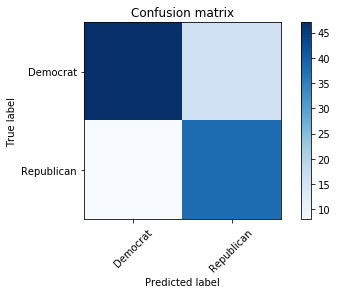

In [35]:
cm = confusion_matrix(ytrue, p)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['Democrat','Republican'])
plt.show()

# Feature Importance
Negative coefficients indicate attributes that are indicative of republican voting.  Positive coefficients indicate attributes that are indicative of democrat voting.

In [36]:
ymod = winners.to_numpy('float32')
regressor = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(x,np.ravel(ymod))

In [37]:
report_coef(
  names,
  np.ravel(regressor.coef_),
  regressor.intercept_)

,coef,positive
"Number; Employed civilian population 16 years and over - INDUSTRY - Finance, insurance, real estate, and rental and leasing",-0.733387,False
Number; Total housing units - UNITS IN STRUCTURE - Mobile home,-0.646445,False
"Number; EDUCATIONAL ATTAINMENT - Population 25 years and over - 9th to 12th grade, no diploma",-0.561603,False
Number; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Cuban,-0.550335,False
Number; RESIDENCE IN 1995 - Population 5 years and over - Different house in the U.S. in 1995 - Same county,-0.509883,False
Number; HOUSING OCCUPANCY - Total housing units - Rental vacancy rate (percent),-0.506553,False
Number; Specified owner-occupied units - MORTGAGE STATUS AND SELECTED MONTHLY OWNER COSTS - With a mortgage - $700 to $999,-0.470395,False
Number; Total housing units - YEAR STRUCTURE BUILT - 1980 to 1989,-0.454941,False
Number; Occupied Housing Units - SELECTED CHARACTERISTICS - Lacking complete kitchen facilities,-0.446731,False
"Number; EDUCATIONAL ATTAINMENT - Population 25 years and over - Some college, no degree",-0.427954,False


Intercept: [0.67510579]


# Regression model
The regression model assumes that the all votes go to either democrats or republicans.  However, because of third parties dVotePct+rVotePct sometimes don't add up to 100%.  This model will perdict the % of voters who vote Democrat in a district and assume that all other votes are Republican.  We assume that if there were no 3rd parties half of the 3rd party votes would go republican and half would go democratic the vote percentages (with such an assumption) are defined to be the adjusted democratic votes and adjusted republican votes respectively adjDVote+adjRVote always equals 100, and the code predicts adjDVote.

In [38]:
#copy the input dataframe, merge the results df, and drop Id2
rdf = df.copy()
rdf = rdf.merge(hres, on="Id2")
rdf.drop("Id2", axis=1, inplace=True)

#calculate the adjusted democratic vote
advTab = rdf.filter(['dVotePct', 'rVotePct'])
rdf.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)
advTab['adjDVote'] = advTab['dVotePct'] + (1-(advTab['dVotePct']+advTab['rVotePct']))/2
advTab.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)
advTab

,adjDVote
0,0.318579
1,0.304794
2,0.395046
3,0.297615
4,0.991275
5,0.008376
6,0.995213
7,0.417186
8,0.458472
9,0.401373


In [39]:
#normalize dataframe
encode_numeric_range(rdf, list(rdf.columns), 0, 1)
rdf

,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,Number; Total population - SEX AND AGE - 35 to 44 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,0.346507,0.289628,0.401684,0.361375,0.500343,0.559825,0.429037,0.271253,0.230556,0.296505,...,0.120014,0.116077,0.103110,0.145708,0.513885,0.494311,0.367890,0.365028,0.282223,0.367448
1,0.346507,0.298007,0.393556,0.315595,0.450421,0.531563,0.410553,0.310724,0.274024,0.294669,...,0.130174,0.113715,0.117802,0.126617,0.652806,0.492763,0.238877,0.223865,0.368536,0.501493
2,0.346507,0.285809,0.405389,0.290408,0.426490,0.486890,0.489440,0.467572,0.248126,0.222964,...,0.113267,0.097180,0.104427,0.191515,0.676432,0.510991,0.284621,0.310398,0.247368,0.469839
3,0.346507,0.307823,0.384034,0.293211,0.399417,0.461522,0.359053,0.227540,0.255317,0.261872,...,0.040679,0.055464,0.020424,0.030845,0.654987,0.498463,0.039848,0.086508,0.302058,0.715549
4,0.346507,0.304914,0.386856,0.302281,0.439954,0.501572,0.378713,0.262461,0.279631,0.419574,...,0.154145,0.133699,0.129661,0.124718,0.462489,0.482699,0.345956,0.402692,0.143816,0.380046
5,0.346507,0.307629,0.384222,0.300354,0.406846,0.490055,0.323563,0.236487,0.331641,0.418070,...,0.096519,0.070960,0.039399,0.050411,0.355627,0.453842,0.347591,0.421396,0.100731,0.352419
6,0.346507,0.234404,0.455257,0.366319,0.483196,0.535603,0.511379,0.458068,0.249822,0.209890,...,0.199905,0.169840,0.236856,0.288970,0.771009,0.495729,0.456871,0.506981,0.111991,0.275310
7,0.326018,0.376607,0.276942,0.421792,0.625304,0.736811,0.480875,0.258080,0.300817,0.558503,...,0.233401,0.210375,0.231519,0.173906,0.742076,0.414319,0.308778,0.295344,0.334194,0.357676
8,0.361269,0.383584,0.339622,0.366397,0.548580,0.680683,0.500837,0.297195,0.160113,0.187350,...,0.097670,0.092455,0.102912,0.128386,0.514830,0.541531,0.280561,0.141168,0.659171,0.501524
9,0.361269,0.324749,0.396697,0.291303,0.420268,0.472457,0.287538,0.133893,0.166460,0.177726,...,0.082986,0.090849,0.086441,0.101570,0.263885,0.517383,0.624354,0.514676,0.435771,0.118933


In [40]:
cx = rdf.to_numpy('float32')
cy = advTab.to_numpy('float32')
print(cx.shape)
print(cy.shape)

(436, 398)
(436, 1)


In [41]:
cxtrain,cxtest,cytrain,cytest=train_test_split(cx, cy, test_size=0.25, random_state=(int(time.time()) % 1000))

In [42]:
ccheckpoint = ModelCheckpoint(filepath="best_weights_regression.hdf5", verbose=1, save_best_only=True)

In [45]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 0.1871 - val_loss: 0.0540
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0435 - val_loss: 0.0375
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0317 - val_loss: 0.0274
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0248 - val_loss: 0.0312
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0220 - val_loss: 0.0256
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0227 - val_loss: 0.0267
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0218 - val_loss: 0.0252
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0224 - val_loss: 0.0244
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

In [48]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='sigmoid'))
cmodel.add(Dense(132, activation='sigmoid'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 0.1376 - val_loss: 0.0672
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0547 - val_loss: 0.0389
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0365 - val_loss: 0.0279
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0292 - val_loss: 0.0271
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0282 - val_loss: 0.0302
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0275 - val_loss: 0.0347
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0260 - val_loss: 0.0266
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0249 - val_loss: 0.0292
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

In [51]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='tanh'))
cmodel.add(Dense(132, activation='tanh'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 1.3045 - val_loss: 0.2460
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.2538 - val_loss: 0.0366
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0778 - val_loss: 0.0337
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0359 - val_loss: 0.0318
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0305 - val_loss: 0.0280
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0250 - val_loss: 0.0278
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0234 - val_loss: 0.0287
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0230 - val_loss: 0.0327
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

In [54]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 0.0483 - val_loss: 0.0490
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0365 - val_loss: 0.0472
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0325 - val_loss: 0.0376
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0304 - val_loss: 0.0481
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0299 - val_loss: 0.0407
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0281 - val_loss: 0.0377
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0266 - val_loss: 0.0342
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0249 - val_loss: 0.0421
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

In [57]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='sigmoid'))
cmodel.add(Dense(132, activation='sigmoid'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 0.0500 - val_loss: 0.0436
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0489 - val_loss: 0.0461
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0484 - val_loss: 0.0550
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0481 - val_loss: 0.0425
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0483 - val_loss: 0.0500
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0497 - val_loss: 0.0439
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0490 - val_loss: 0.0415
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0474 - val_loss: 0.0447
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

In [60]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='tanh'))
cmodel.add(Dense(132, activation='tanh'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='sgd')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(cxtrain, cytrain, validation_data=(cxtest,cytest), callbacks=[cmonitor,ccheckpoint], batch_size=24, verbose=2, epochs=100)

Train on 327 samples, validate on 109 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from 0.02232
327/327 - 1s - loss: 0.4942 - val_loss: 0.3904
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.1436 - val_loss: 0.1217
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0487 - val_loss: 0.0349
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0356 - val_loss: 0.0322
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0495 - val_loss: 0.0799
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0479 - val_loss: 0.0772
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0430 - val_loss: 0.0505
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.02232
327/327 - 0s - loss: 0.0378 - val_loss: 0.0307
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.02232
32

# The Best Model

In [61]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1]))
cmodel.compile(loss='mean_squared_error', optimizer='adam')
cmodel.load_weights('best_weights_regression.hdf5')

In [62]:
cpred = cmodel.predict(cxtest)
for i in range(10):
    print("{}. Actual Dem % of vote: {}\t\tPredicted Dem % of vote: {}".format(i+1,cytest[i][0],cpred[i][0]))

1. Actual Dem % of vote: 0.39812126755714417		Predicted Dem % of vote: 0.3991983234882355
2. Actual Dem % of vote: 0.3845974802970886		Predicted Dem % of vote: 0.6148127317428589
3. Actual Dem % of vote: 0.3695697784423828		Predicted Dem % of vote: 0.49013328552246094
4. Actual Dem % of vote: 0.5500441789627075		Predicted Dem % of vote: 0.35806891322135925
5. Actual Dem % of vote: 0.70716392993927		Predicted Dem % of vote: 0.5523340106010437
6. Actual Dem % of vote: 0.927293062210083		Predicted Dem % of vote: 0.4871455132961273
7. Actual Dem % of vote: 0.7047924399375916		Predicted Dem % of vote: 0.5576985478401184
8. Actual Dem % of vote: 0.7679800391197205		Predicted Dem % of vote: 0.9213063716888428
9. Actual Dem % of vote: 0.6987696290016174		Predicted Dem % of vote: 0.6061655282974243
10. Actual Dem % of vote: 0.8593315482139587		Predicted Dem % of vote: 0.729617178440094


In [63]:
pctToParty = ['Republican', 'Democrat']
for i in range(11,20):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,pctToParty[int(np.round(cytest[i][0]))],pctToParty[int(np.round(cpred[i][0]))]))

12. Actual Party: Republican		Predicted Party: Republican
13. Actual Party: Democrat		Predicted Party: Democrat
14. Actual Party: Republican		Predicted Party: Republican
15. Actual Party: Republican		Predicted Party: Republican
16. Actual Party: Democrat		Predicted Party: Democrat
17. Actual Party: Democrat		Predicted Party: Democrat
18. Actual Party: Democrat		Predicted Party: Democrat
19. Actual Party: Democrat		Predicted Party: Democrat
20. Actual Party: Republican		Predicted Party: Republican


In [64]:
score = np.sqrt(metrics.mean_squared_error(cmodel.predict(cxtest),cytest))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.1493920385837555


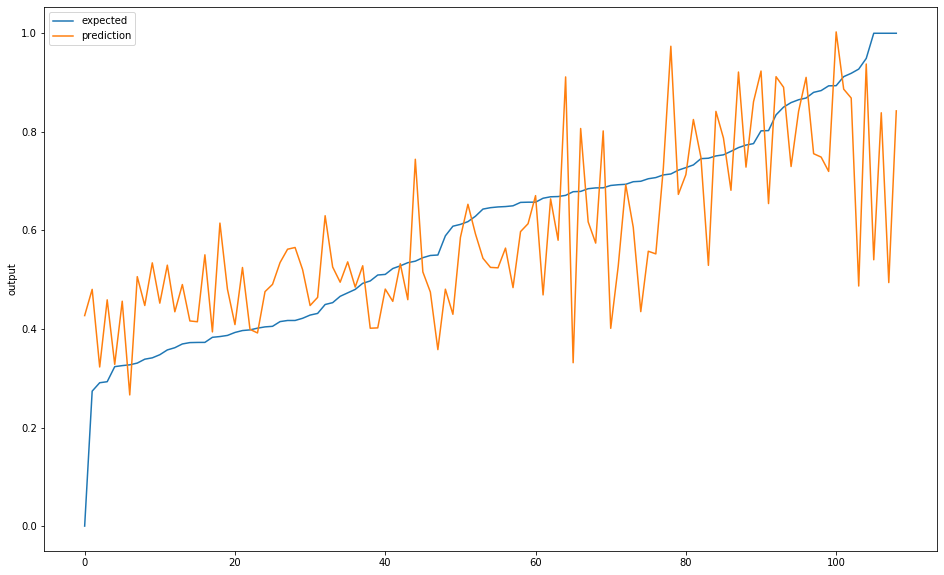

<Figure size 576x432 with 0 Axes>

In [65]:
crxtest=cxtest[0:109]
crytest=cytest[0:109]
chart_regression(cmodel.predict(cxtest).flatten(),cytest, sort=True)

In [66]:
cytrue = np.round(cytest)
cp = np.round(cpred)
accuracy = metrics.accuracy_score(cytrue,cp)
print("Accuracy score: {}".format(accuracy))
prec = metrics.precision_score(cytrue, cp, average="weighted")
print("Precision score: {}".format(prec))
recall = metrics.recall_score(cytrue, cp, average="weighted")
print("Recall score: {}".format(recall))
f1 = metrics.f1_score(cytrue, cp, average="weighted")
print("F1 score: {}".format(f1))
print("\n\t\t\tCLASSIFICATION REPORT\n")
print(metrics.classification_report(cytrue, cp))

Accuracy score: 0.7339449541284404
Precision score: 0.7355238665071134
Recall score: 0.7339449541284404
F1 score: 0.7346718142847237

			CLASSIFICATION REPORT

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63        39
         1.0       0.80      0.79      0.79        70

    accuracy                           0.73       109
   macro avg       0.71      0.71      0.71       109
weighted avg       0.74      0.73      0.73       109



[[25 14]
 [15 55]]


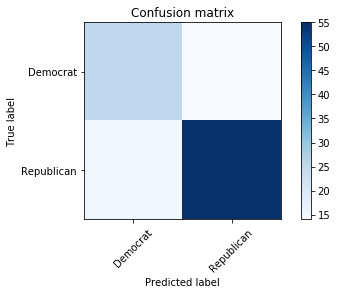

In [67]:
ccm = confusion_matrix(cytrue, cp)
print(ccm)
plt.figure()
plot_confusion_matrix(ccm, ['Democrat','Republican'])
plt.show()